# COMP9517: Computer Vision #
## velocity_estimation.ipynb ##
### Implementation of velocity estimation approach with evaluations & test cases ###

# Importing relevant packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import copy
from evaluate.velocity import VeloEval

# Get bbox and velocity annotations

In [2]:
def getCar(annotations):
    # Open annotation.json
    f = open(annotations, 'r')
    train = json.load(f)

    f.close() # close after use

    # Getting bbox coordinates
    top = int(train[0]["bbox"]["top"])
    bottom = int(train[0]["bbox"]["bottom"])
    left = int(train[0]["bbox"]["left"])
    right = int(train[0]["bbox"]["right"])

    # Grab velocity values
    velz = train[0]["velocity"][0]
    vely = train[0]["velocity"][1]

    return left, right, top, bottom, velz, vely

# Calculate relative distance of detected vehicle #
### As implemented in Task 1 ###

In [3]:
def calculate_distance(x1, x2, y1, y2, p1 = 670):
    cx = 713.85
    fx = 714.1526

    pixel_w = x2 - x1
    pixel_h = y2 - y1
    
    w = -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356
    '''(-0.030522707866872622,
            0.019645624118997243,
            -0.026543674714586008,
            -1.3394041753397261e-05,
            12.566680966429356)'''
    
    pred_z0 = fx * w / pixel_w
    
    if pred_z0 > 45:
        w = -0.028121 * y1 + 0.01575292 * pixel_w - 0.08113623 * pixel_h +0.00143413 *  pixel_w * pixel_h + 12.180052129300515
    elif pred_z0 <= 45 and pred_z0 > 17: 
        w = -0.03920957 * y1 + 0.03809848 * pixel_w -0.02960555 * pixel_h -0.00017222 *  pixel_w * pixel_h + 15.04862701217894
    else:
        w = -2.23215766e-02 * y1 + 1.42389457e-02 * pixel_w -2.57650913e-02 * pixel_h + 4.97360611e-06 *  pixel_w * pixel_h + 10.143259937723007
    
    pred_z0 = fx * w / pixel_w
    pred_x0 = (x1 - p1) * pred_z0/fx

    return pred_z0, pred_x0

# Predict velocity of vehicle over 5 frames #

# Preliminary setting up #

In [4]:
# Getting the filepaths
dataset_path = './clips'

folder_path = os.listdir(dataset_path)
folder_path = [int(x) for x in folder_path]
folder_path.sort()
folder_path = [str(x) for x in folder_path]

# List of annotation path for each clip
annotations = [os.path.join(dataset_path, x, 'annotation.json') for x in folder_path]

# Load the annotations
gt = VeloEval.load_annotation(annotations)

# Create a copy 
gt_pred = copy.deepcopy(gt) 

# Open data.txt which provides the bounding box results detected from our YOLO detection model
f = open('data.txt', 'r')
data = json.load(f)
f.close() # close

Finished loading 1074 annotations.


# Predict velocity #
## Display velocity on image ##

In [11]:
def predict_velocity(imgNum, img_40):
    # grab all bbox dimensions for frame 35 as detected by YOLO
    bbox_35 = data[imgNum - 1]['35']

    gtIndex = imgNum - 1

    # grab all bbox dimensions for frame 40 as detected by YOLO
    bbox_40 = data[imgNum - 1]['40']

    # need to match bbox from frame 35 and frame 40 to ensure we are calculating velocity on the same recognised vechile
    for box in bbox_40:
        # extract coordinates of cars in frame 40
        x1, y1, x2, y2 = box
        # initialise minimum difference to positive infinity
        minDiff = math.inf
        # loop through bboxes in frame 35
        for nextBox in bbox_35:           
            # calculate the difference = the sum of the absolute value of the difference in each pixel coordinate
            difference = np.sum(np.abs(np.subtract(nextBox, box)))

            # we take the minimised difference - which suggests that it is the closest bbox
            if difference < minDiff:
                # by the end of the loops, we will have the coordinates of the closest bbox = matching vehicles
                minDiff = difference
                X1, Y1, X2, Y2 = nextBox
        
        # calculate distance 
        z35, y35 = calculate_distance(X1, X2, Y1, Y2)
        z40, y40 = calculate_distance(x1, x2, y1, y2)

        # set change in time (as frameTime)
        frameTime = 5 * 2 / 40
        
        # velocity calculation
        zDiff = z40 - z35
        zVel = round(zDiff / frameTime, 3)
        yDiff = y40 - y35
        yVel = round(yDiff / frameTime, 3)

        # display on image
        text = 'v: (' + str(zVel) + ', ' + str(yVel) + ') m/s'
        cv2.rectangle(img_40, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_40,text,(x1,y1 - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 4)

    plt.imshow(img_40)
    plt.show()

# Evaluate velocity estimation model #

In [6]:
def evaluate(imgNum):
    # grab bboxes in frame 35 detected by YOLO
    bbox_35 = data[imgNum - 1]['35']

    gtIndex = imgNum - 1
    
    # get ground truth bbox label
    annot = './clips/' + str(imgNum) + '/annotation.json'
    x1, x2, y1, y2, _, _ = getCar(annot)

    X1 = x1 
    X2= x2 
    Y1 = y1 
    Y2 = y2

    bbox_40 = [x1, y1, x2, y2]

    minDiff = math.inf

    # find matching bbox
    for box in bbox_35:
        difference = np.sum(np.abs(np.subtract(box, bbox_40)))
        if difference < minDiff:
            minDiff = difference
            X1, Y1, X2, Y2 = box
        
    # calculate distance
    z35, y35 = calculate_distance(X1, X2, Y1, Y2)
    z40, y40 = calculate_distance(x1, x2, y1, y2)

    frameTime = 5 * 2 / 40

    # velocity estimation
    zDiff = z40 - z35
    zVel = zDiff / frameTime

    yDiff = y40 - y35
    yVel = yDiff / frameTime

    # replace copy of gt velocity values with calculated values
    gt_pred[gtIndex][0]["velocity"][0] = zVel
    gt_pred[gtIndex][0]["velocity"][1] = yVel

    return gt_pred[gtIndex]

# Driving code to predict vehicles in the TuSimple benchmark_velocity_training dataset #

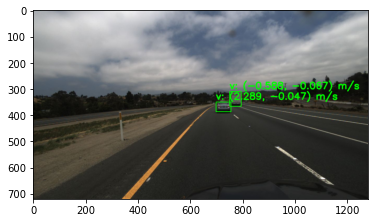

In [13]:
for i in range(378, 379):
    annot = os.path.join(dataset_path, str(i), 'annotation.json')
    imagePath = os.path.join(dataset_path, str(i), 'imgs/040.jpg')
    image = cv2.imread(imagePath, 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1, x2, y1, y2, _, _ = getCar(annot)
    predz0, predx0 = calculate_distance(x1, x2, y1, y2)
    predict_velocity(i, image)

# Evaluation of our approach #

In [17]:
pred = copy.deepcopy(gt)
for i in range(1, 1074):
    imagePath = os.path.join(dataset_path, str(i), 'imgs/040.jpg')
    result = evaluate(i)
    pred[i - 1] = result

In [18]:
VeloEval.accuracy(pred, gt)

Velocity Estimation error (Near): 16.90006
Velocity Estimation error (Medium): 179.26929
Velocity Estimation error (Far): 1123.73019
Velocity Estimation error total:  439.966511


(439.96651143822356, 0.0)